<a href="https://colab.research.google.com/github/seyma-tas/image-classification-project/blob/master/Copy_of_final_x_ray_pneumonia_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Introduction
## Define the Problem
Disease diagnosis with radiology is a common practice in medicine  that requires doctors to interpret the results from the x-ray images. Due to the increase in the number of patients and the low availability of doctors, there was a need for a new method to diagnose .
Fortunately machine learning has introduced the solution for this problem . In this project we are going to introduce deep learning models and techniques in diagnosing pneumonia.


# CNN

Layers used to build ConvNets. As we described above, a simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks). We will stack these layers to form a full ConvNet architecture.

In [ ]:
import warnings
warnings.filterwarnings('ignore')



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', color_codes=True)

import os
import datetime
# import pydot
import tensorflow as tf
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import plot_model
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix
#from src import plots
from matplotlib.pyplot import *
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

Using TensorFlow backend.


In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Function to create a dictionary of model's train, validation and test results

def store_results_to_dict(model, model_description):
    from sklearn.metrics import precision_score, recall_score, f1_score
    train_loss, train_acc = model.evaluate_generator(train_generator, steps=50)
    val_loss, val_acc = model.evaluate_generator(val_generator, steps=50)
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
    pred = model.predict_generator(test_generator, test_steps_per_epoch)
    pred_classes = np.round(pred)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    precision_score = precision_score(true_classes, pred_classes)
    recall_score = recall_score(true_classes, pred_classes)
    f1_score = f1_score(true_classes, pred_classes)
    curr_dict = { 'Model':model_description
                 ,'Train Accuracy': train_acc
                 ,'Train Loss': train_loss
                 ,'Validation Accuracy':val_acc
                 ,'validation Loss':val_loss
                 ,'Test Accuracy':test_acc
                 ,'Test Loss':test_loss
                 ,'Precision':precision_score
                 ,'Recall':recall_score
                 ,'f1':f1_score
                  }
    return curr_dict

In [ ]:
def plot_acc_and_loss(model_history):
  acc = model_history.history['acc']
  val_acc = model_history.history['val_acc']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(figsize=(16,7))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy',fontsize=20 )
  plt.legend()
  plt.figure(figsize=(16,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss', fontsize=20)
  plt.legend()
  plt.show()

In [ ]:
def plot_confusion_matrix(model, result, generator, labels):
    preds = model.predict_generator(generator)
    acc = accuracy_score(labels, np.round(preds))*100
    cm = confusion_matrix(labels, np.round(preds))
    tn, fp, fn, tp = cm.ravel()
    classes=np.unique(labels)
    normalize=False
    title='Confusion matrix'
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Stage 1: Loading and pre-processing the data

In [ ]:
# train, test and validation directories of x-ray dataset images 
train_data_dir=('/content/drive/My Drive/image-classification-project 4/data/train')
val_data_dir=('/content/drive/My Drive/image-classification-project 4/data/val')
test_data_dir=('/content/drive/My Drive/image-classification-project 4/data/test')

## Obtain Data:
### About the X-ray images data:
An input of  total x-ray images of 4,704  were  downloaded  from kaggle, 
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. 
The data images in  kaggle was not split appropriately, so we split the images  manually  with percentages of :60% train, 20% val, 20% test.
Our image data were as follows:


### Train data:
2480 images belong to 2 classes: Normal and pneumonia.The Normal images in the training set  are 878 images, while the pneumonia images are 1604 images which is almost double the number.

### Validation Data:
There are 1102 images belonging to 2 classes:Normal and pneumonia.The Normal images in the training set  are 322 images, while the pneumonia images are 802 images which is almost double the number.
### Test data:
There are 1102 images belonging to 2 classes:Normal and pneumonia.The Normal images in the training set  are 321 images, while the pneumonia images are 781 images which is almost double the number.
. 


In [ ]:
# counting number of normal images and pneumonia images in each dataset of training, testing and validation
path='/content/drive/My Drive/image-classification-project 4/data/'
# Numbers of pneumonia and normal images in each set
for folder in ['train', 'val', 'test']:
    n_normal = len(os.listdir(path + folder + '/NORMAL'))
    n_pneumonia = len(os.listdir(path + folder + '/PNEUMONIA'))
    print("There are {} normal x-ray images and {} pnemonia x-ray images in {} set. ".format(n_normal, n_pneumonia, folder))

There are 878 normal x-ray images and 1604 pnemonia x-ray images in train set. 
There are 322 normal x-ray images and 802 pnemonia x-ray images in val set. 
There are 321 normal x-ray images and 781 pnemonia x-ray images in test set. 


In [ ]:
total_images_train_normal = os.listdir(path + 'train/NORMAL')
total_images_train_pneumonia = os.listdir(path + 'train/PNEUMONIA')

total_images_test_normal = os.listdir(path + 'test/NORMAL')
total_images_test_pneumonia = os.listdir(path + 'test/PNEUMONIA')

total_images_val_normal = os.listdir(path + 'val/NORMAL')
total_images_val_pneumonia = os.listdir(path + 'val/PNEUMONIA')

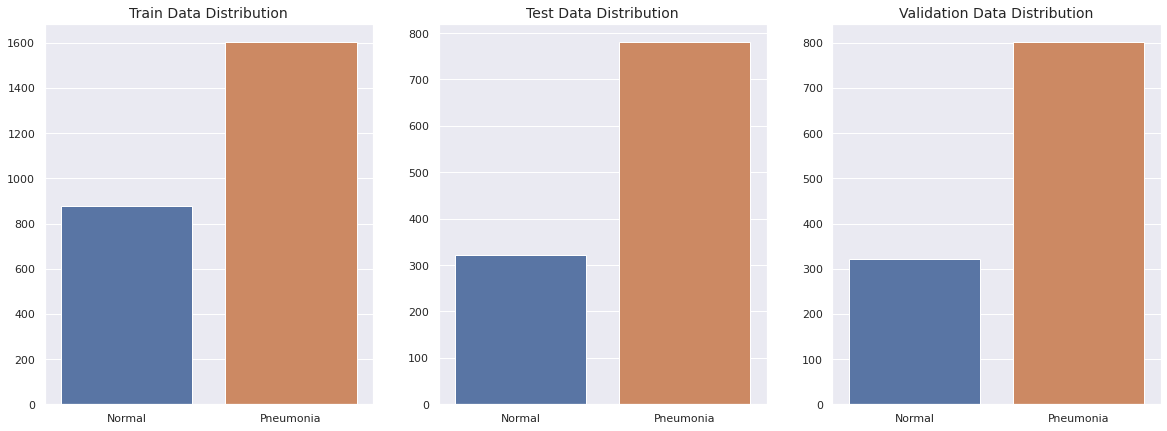

In [ ]:
# plot shows the number of normal images versus pneumonia images in Train, Val and test set
plt.figure(figsize=(20, 7))
plt.subplot(131)
plt.title('Train Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])
plt.subplot(132)
plt.title('Test Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_test_normal),len(total_images_test_pneumonia)])
plt.subplot(133)
plt.title('Validation Data Distribution', fontsize=14)
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_val_normal),len(total_images_val_pneumonia)])
plt.show()

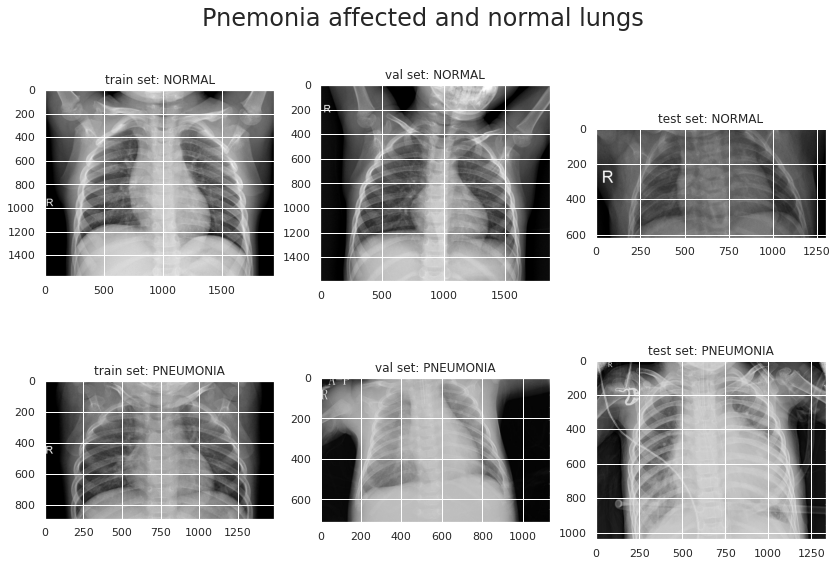

In [ ]:
# displaying noraml x-ray images and pneumonia x-ray images in train, test and val using imshow,imread
fig, ax = plt.subplots(2, 3, figsize=(14, 9))
ax = ax.ravel()

fig.suptitle('Pnemonia affected and normal lungs', fontsize=24)

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('{} set: NORMAL'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('{} set: PNEUMONIA'.format(_set))


In [ ]:
# Get all the data in the directory DATA/TRAIN, and reshape them
print("Train data:")
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_data_dir,
                                                                         target_size=(150, 150), batch_size=32, class_mode='binary')

# Get all the data in the directory DATA/TEST , and reshape them    
print("Test data:")                                                                  
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                        target_size=(150, 150), batch_size=32, class_mode='binary')

# Get all the data in the directory DATA/VAL, and reshape them
print("Validation data:")  
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,
                                                                       target_size=(150, 150), batch_size=32, class_mode='binary')

Train data:
Found 2480 images belonging to 2 classes.
Test data:
Found 1102 images belonging to 2 classes.
Validation data:
Found 1122 images belonging to 2 classes.


In [ ]:
# counting the stepsize per epoch
train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
val_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

# Methodology:
# Question1: How is an image classification model typically designed?
We can divide this process broadly into 4 steps. Each step requires a certain amount of time to execute: https://www.analyticsvidhya.com/blog/2019/01/

## build-image-classification-model

Loading and pre-processing Data – 30% time

Defining Model architecture – 10% time

Training the model – 50% time

Estimation of performance – 10% time
 
Training the model
For training the model, we require:

Training images and their corresponding true labels

Validation images and their corresponding true labels (we use these labels only 

to validate the model and not during the training phase).

We also define the number of epochs. we ran all the models for 30 epochs


## Training the model
For training the model, we require:

Training images and their corresponding true labels, used  CNN deep learning 

and adjust weights(parameters) through hypertuning parameters such as: Padding,

Dropout, Elastic Net,Augmentation techniques,Transfer Learning Techniques,VGG16.

 Validation images and their corresponding true labels (we use these labels only 

to validate the model and not during the training phase)

We also define the number of epochs. we ran all the models for 30 epochs


# Baseline Model

In my base model, i'm going to use 4 different conv layers with max pooling and after that I will apply a dense layer with 512 neurons and finally the output layer with one neuron.

* Important NOte* Number of filters which is same as number of features has been increasing in my conv layers from 32 to 64 to 128. With each conv layers, we are going to double the number of filters i'm going to use.Another thing with max pooling 2 by 2, we are reducing the size of our images , so the image of 150 by 150, after first max pooling will be 75 by 75. Then the image size after second max pooling will be 37 by 37. Then after third max pooling image size will be 18 by 18. Then the last image size 9 by 9. As we go along in our neural network number of features (filters) are increasing while the weight and length of our images are decreasing. So image size should decrease with each conv layer and the feature map height length increase as we go along the neural network

In [ ]:

#Baseline Model
model0 = Sequential()

# Fist Conv layer with 32 filters,3 by 3 window, input size 150 by 150 by 3 for RGB as third dimension
model0.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
#First Max Pooling  layer with window 2 by 2
model0.add(MaxPooling2D(pool_size = (2, 2)))

#  Second Conv layer with filter =64, window=3 by 3 
model0.add(Conv2D(64, (3, 3), activation="relu"))
# 2d Pooling layer with window 2 by 2
model0.add(MaxPooling2D(pool_size = (2, 2)))

# Third Conv layer with 128 features, window=3 by 3
model0.add(Conv2D(128, (3, 3), activation='relu'))
# 3rd Pooling layer with window 2 by 2
model0.add(MaxPooling2D((2, 2)))

# Forth Conv layer with 128 features, window=3 by 3
model0.add(Conv2D(128, (3, 3), activation='relu'))
# 4th Pooling layer with window 2 by 2
model0.add(MaxPooling2D((2, 2)))

# Flatten the layer
model0.add(Flatten())

# Fully Connected Layers
# single dense layer with 512 neurons
model0.add(Dense(activation = 'relu', units = 512))

#single output layer with one neuron since we only want to predict two classes
model0.add(Dense(activation = 'sigmoid', units = 1))
model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

Number of Trainable parameters about 3.5 milion and with this big number, I can expect issue of overfitting

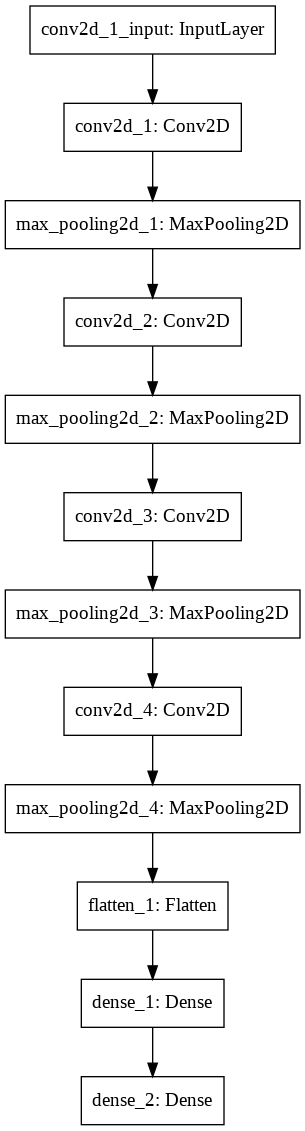

In [ ]:
#structure of Base model
plot_model(model0)
# looking at the structure of my neural network

In [ ]:
# Compile the Neural network
model0.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), ### learning rate 0.0001
              metrics=['acc'])


In [ ]:
# ⏰ This cell may take several minutes to run

# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)

start = datetime.datetime.now()
history = model0.fit_generator(train_generator, 
                              steps_per_epoch=train_steps_per_epoch, 
                              epochs=30, 
                              validation_data=val_generator, 
                              validation_steps=val_steps_per_epoch)
end = datetime.datetime.now()
elapsed = end - start
print('\n ---------Elapsed Time-----------')
print('Time to fit baseline model is:\n {}'.format(elapsed))

Epoch 1/30
78/78 [==============================] - 906s 12s/step - loss: 0.5225 - acc: 0.7536 - val_loss: 0.1945 - val_acc: 0.8957
Epoch 2/30
78/78 [==============================] - 35s 448ms/step - loss: 0.2858 - acc: 0.8871 - val_loss: 0.0149 - val_acc: 0.9403
Epoch 3/30
78/78 [==============================] - 35s 451ms/step - loss: 0.1797 - acc: 0.9274 - val_loss: 0.0030 - val_acc: 0.9447
Epoch 4/30
78/78 [==============================] - 35s 450ms/step - loss: 0.1479 - acc: 0.9431 - val_loss: 0.0134 - val_acc: 0.9635
Epoch 5/30
78/78 [==============================] - 35s 444ms/step - loss: 0.1251 - acc: 0.9512 - val_loss: 0.0506 - val_acc: 0.9670
Epoch 6/30
78/78 [==============================] - 33s 425ms/step - loss: 0.1066 - acc: 0.9601 - val_loss: 0.0055 - val_acc: 0.9679
Epoch 7/30
78/78 [==============================] - 33s 421ms/step - loss: 0.0974 - acc: 0.9657 - val_loss: 3.9086e-04 - val_acc: 0.9528
Epoch 8/30
78/78 [==============================] - 34s 436ms/step

In [ ]:
results=store_results_to_dict(model0, 'Base Model(with 4 conv,pooling layers,and dense full conv layer)')
results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss
0,"Base Model(with 4 conv,pooling layers,and dens...",1.0,0.004448,0.980392,6.014753e-07,0.869328,0.227374


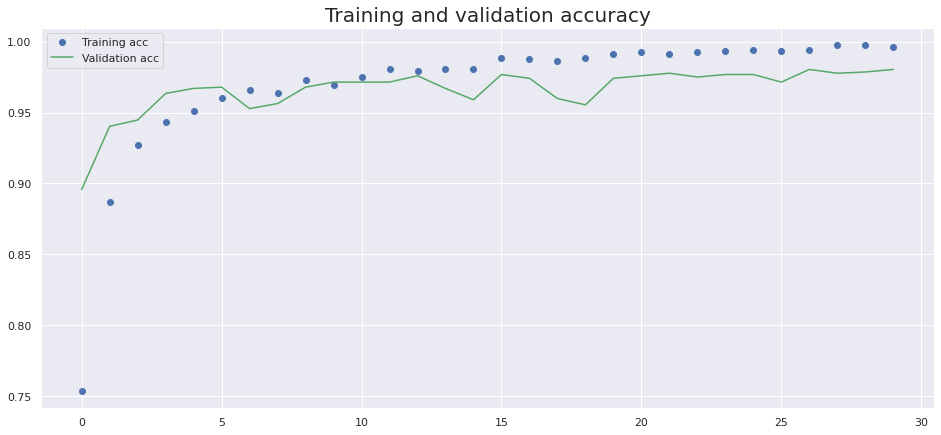

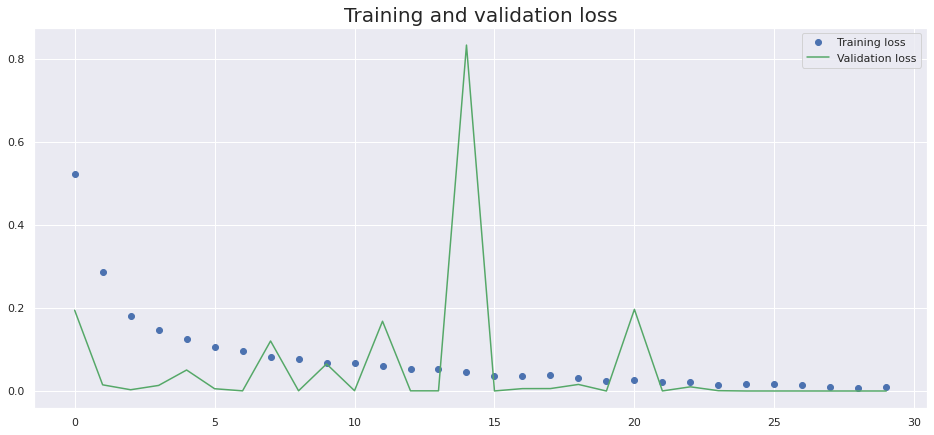

In [ ]:
plot_acc_and_loss(history)


# Hyperparameter Tuned Model

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', input_shape=(150,150, 3)))
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))


cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

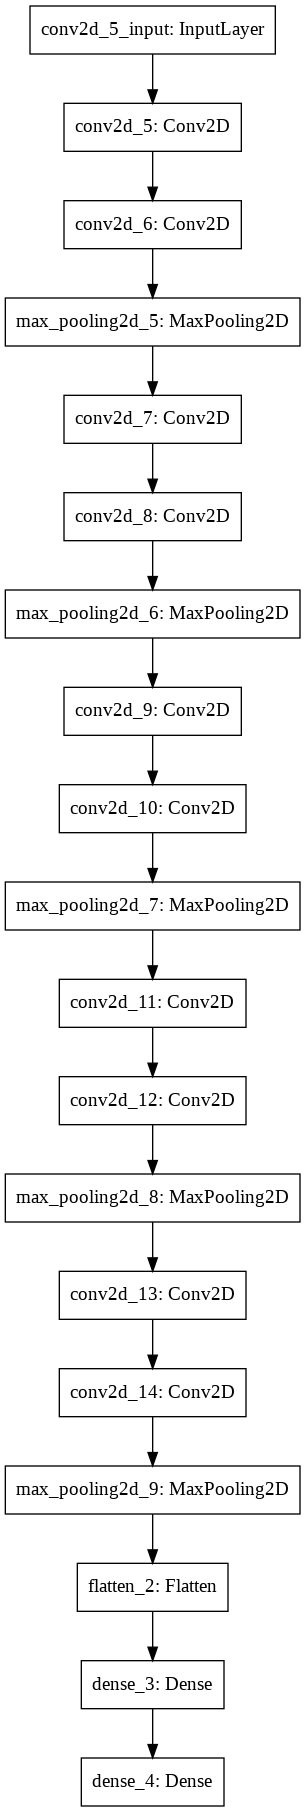

In [ ]:
#structure of Base model
plot_model(cnn)
# looking at the structure of my neural network

In [ ]:
optimizer = Adam(lr=0.0001, decay=1e-5)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 8)       1184      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 8)       3144      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 16)        3216      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 16)        6416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)       

In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run
start = datetime.datetime.now()
cnn_history = cnn.fit_generator(train_generator,
                                epochs=30,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_generator, 
                                validation_steps=val_steps_per_epoch)
   
end = datetime.datetime.now()
elapsed = end - start
print('---------Elapsed Time-----------')
print('Time to fit tuned model is:\n {}'.format(elapsed))

Epoch 1/30
78/78 [==============================] - 39s 502ms/step - loss: 0.6435 - acc: 0.6427 - val_loss: 0.6059 - val_acc: 0.8734
Epoch 2/30
78/78 [==============================] - 35s 444ms/step - loss: 0.3351 - acc: 0.8613 - val_loss: 0.1629 - val_acc: 0.9171
Epoch 3/30
78/78 [==============================] - 35s 445ms/step - loss: 0.1760 - acc: 0.9339 - val_loss: 0.0552 - val_acc: 0.9492
Epoch 4/30
78/78 [==============================] - 35s 454ms/step - loss: 0.1313 - acc: 0.9496 - val_loss: 0.0101 - val_acc: 0.9474
Epoch 5/30
78/78 [==============================] - 36s 455ms/step - loss: 0.1091 - acc: 0.9589 - val_loss: 5.4638e-05 - val_acc: 0.9581
Epoch 6/30
78/78 [==============================] - 36s 457ms/step - loss: 0.1081 - acc: 0.9569 - val_loss: 0.0022 - val_acc: 0.9537
Epoch 7/30
78/78 [==============================] - 35s 451ms/step - loss: 0.0947 - acc: 0.9669 - val_loss: 0.0035 - val_acc: 0.9617
Epoch 8/30
78/78 [==============================] - 36s 456ms/ste

In [ ]:
results=store_results_to_dict(cnn, 'Hyperparameter tuned model(padding, adam)')
# results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss
0,"Base Model(with 4 conv,pooling layers,and dens...",1.000000,0.004448,0.980392,6.014753e-07,0.869328,0.227374
1,"Hyperparameter tuned model(padding, adam)",0.995968,0.000760,0.965241,3.385009e-07,0.832123,1.097643


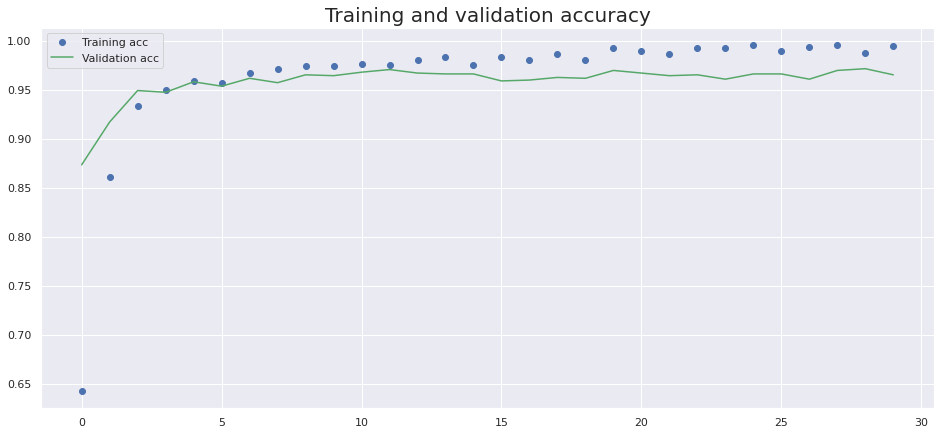

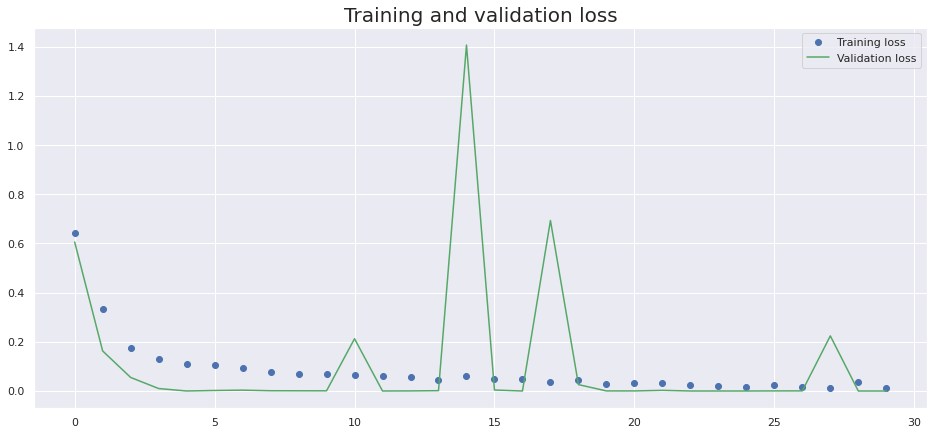

In [ ]:
plot_acc_and_loss(cnn_history)

# Regularized model(Dropout and Elasticnet)



In [ ]:
cnn = Sequential()
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2(), input_shape=(150, 150, 3)))
cnn.add(Conv2D(8, (7, 7), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (3, 3)))

cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l1_l2(),bias_regularizer=l1_l2()))
cnn.add(Dropout(0.1))
cnn.add(MaxPooling2D(pool_size = (2, 2)))


cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation='sigmoid'))

In [ ]:
optimizer = Adam(lr=0.0001, decay=1e-5)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
cnn.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 8)       1184      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 8)       3144      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 16)        3216      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 16)        6416      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 16)       

Regularizing our model with Dropout and Elasticnet lead to decrease of our trainable parameters to about 370.5 parameter, let's see we overcome the overfitting issue here.

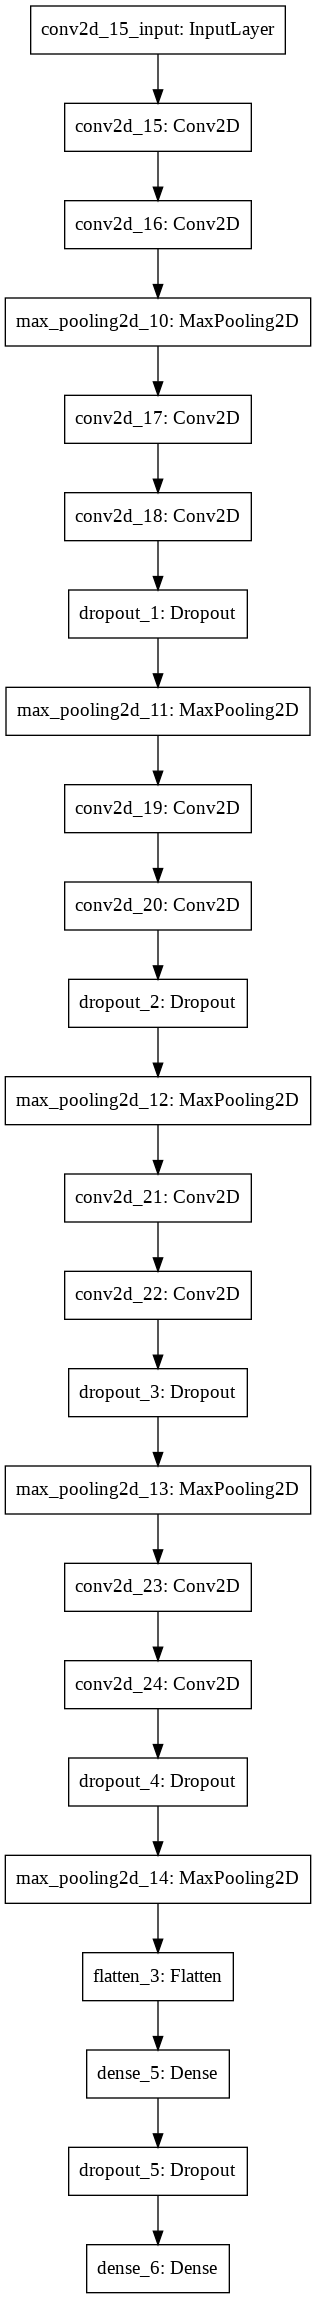

In [ ]:
plot_model(cnn)

In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run
start = datetime.datetime.now()
cnn_history = cnn.fit_generator(train_generator,
                                epochs=30,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_generator, 
                                validation_steps=val_steps_per_epoch)
end = datetime.datetime.now()
elapsed = end - start
print('---------Elapsed Time-----------')
print('Time to fit regularized model is:\n {}'.format(elapsed))

Epoch 1/30
78/78 [==============================] - 39s 498ms/step - loss: 87.0572 - acc: 0.6440 - val_loss: 75.4664 - val_acc: 0.7139
Epoch 2/30
78/78 [==============================] - 35s 444ms/step - loss: 65.4355 - acc: 0.6464 - val_loss: 55.7452 - val_acc: 0.7139
Epoch 3/30
78/78 [==============================] - 35s 445ms/step - loss: 47.3276 - acc: 0.6464 - val_loss: 39.1575 - val_acc: 0.7139
Epoch 4/30
78/78 [==============================] - 36s 457ms/step - loss: 32.6121 - acc: 0.6464 - val_loss: 26.3567 - val_acc: 0.7139
Epoch 5/30
78/78 [==============================] - 35s 443ms/step - loss: 21.1796 - acc: 0.6464 - val_loss: 16.5490 - val_acc: 0.7139
Epoch 6/30
78/78 [==============================] - 35s 449ms/step - loss: 12.9066 - acc: 0.6464 - val_loss: 9.5790 - val_acc: 0.7139
Epoch 7/30
78/78 [==============================] - 35s 443ms/step - loss: 7.6645 - acc: 0.6464 - val_loss: 5.7689 - val_acc: 0.7139
Epoch 8/30
78/78 [==============================] - 35s 44

In [ ]:
results=store_results_to_dict(cnn, 'Regularized Model(Dropout, Ridge-Lasso)')
# results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss
0,"Base Model(with 4 conv,pooling layers,and dens...",1.000000,0.004448,0.980392,6.014753e-07,0.869328,0.227374
1,"Hyperparameter tuned model(padding, adam)",0.995968,0.000760,0.965241,3.385009e-07,0.832123,1.097643
2,"Regularized Model(Dropout, Ridge-Lasso)",0.646371,0.768241,0.713904,4.986237e-01,0.708711,0.614174


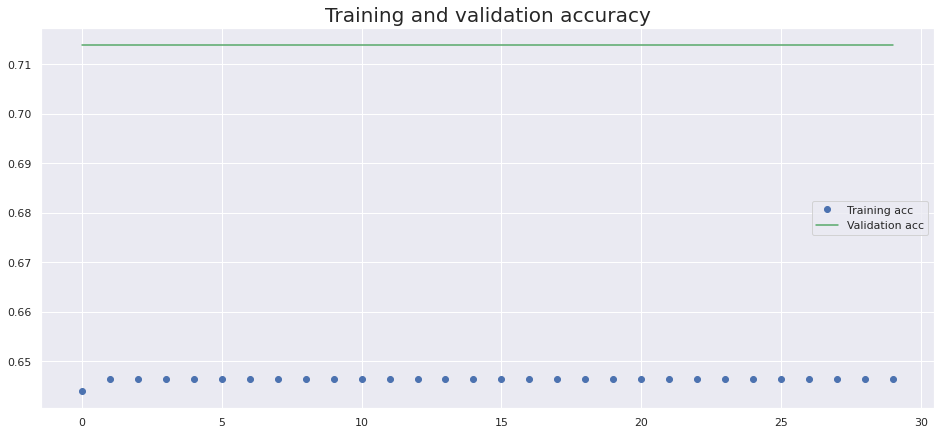

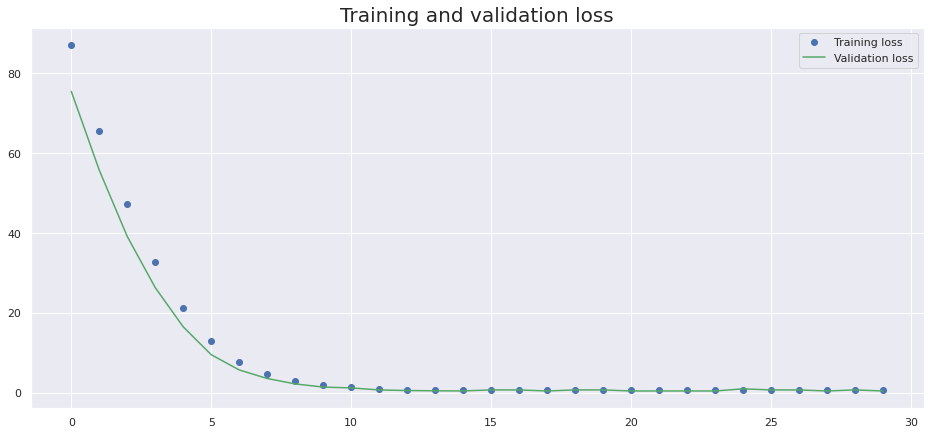

In [ ]:
plot_acc_and_loss(cnn_history)

## Augmented Model
Data Augmentation

Now, I will try to use Augmentation techniques to create dummy augmented data in order to increase the previous model accuracy as follows:

Shearing: pulling anyone off our photo and converting square into rhombus

Rotation: Rotating the image

Width shift: shift the image to the right or to the left

Height Shift: shifting whole image up and down

Zooming: zoom in at any particular section o our image.

Horizontal flip: mirror image along the vertical axis

In [ ]:
# Define The parameters of my image transformation
train_datagen = ImageDataGenerator(rotation_range=40, # rotating from -40 to40 degree
                               	width_shift_range=0.2, # allowing image generator to shift our images left or right  about 20% of total width
                               	height_shift_range=0.2,#allowing image generator to shift our images up or dowm  about 20% of total height
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')
 

 
train_generator = train_datagen.flow_from_directory(
    	# This is the target directory
    	train_data_dir,
    	# All images will be resized to 150x150
    	target_size=(150, 150),
    	batch_size=32,
    	# Since we use binary_crossentropy loss, we need binary labels
    	class_mode='binary')
test_datagen = ImageDataGenerator(rescale=1./255) 
val_generator = test_datagen.flow_from_directory(val_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')


Found 2480 images belonging to 2 classes.
Found 1122 images belonging to 2 classes.
Found 1102 images belonging to 2 classes.


In [ ]:
model1 = Sequential()
model1.add(Conv2D(8, (7, 7), padding='same', activation='relu', input_shape=(150,150, 3)))
model1.add(Conv2D(8, (7, 7), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (3, 3)))

model1.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
model1.add(Conv2D(16, (5, 5), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (3, 3)))
model1.add(Dropout(0.1))

model1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.1))

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.1))

model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.1))


model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

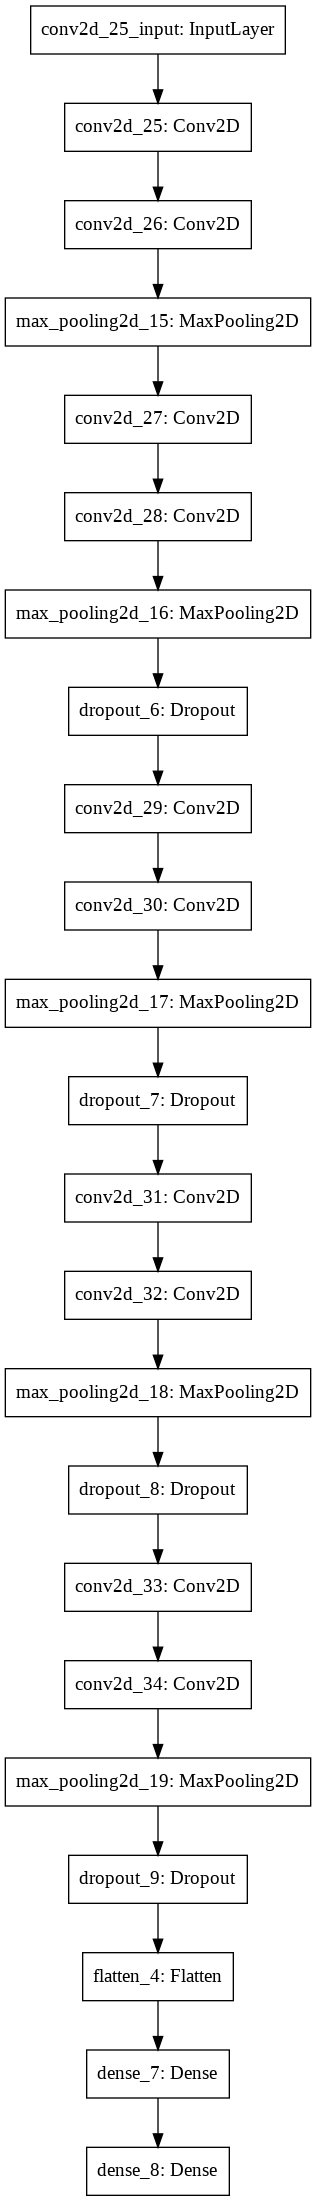

In [ ]:
# looking at the structure of my augmented CNN 
plot_model(model1)


In [ ]:
#compiling and Optimizing Augmented model
optimizer = Adam(lr=0.0001, decay=1e-5)
model1.compile(loss='binary_crossentropy',
          	optimizer=optimizer,
          	metrics=['acc'])
model1.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 150, 150, 8)       1184      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 150, 150, 8)       3144      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 50, 50, 16)        3216      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 50, 50, 16)        6416      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 16)       

In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run

# fitting my model with training data
start = datetime.datetime.now()
history = model1.fit_generator(train_generator,
                          	steps_per_epoch=train_steps_per_epoch,# overall we are feeding 3200 images in every epoch of training our model because steps per epochs =100
                          	epochs=30,
                          	validation_data=val_generator,
                          	validation_steps=val_steps_per_epoch)

end = datetime.datetime.now()
elapsed = end - start 
print('---------Elapsed Time-----------')
print('Time to fit augmented model is:\n {}'.format(elapsed))


Epoch 1/30
78/78 [==============================] - 49s 627ms/step - loss: 0.7404 - acc: 0.5960 - val_loss: 0.6845 - val_acc: 0.7139
Epoch 2/30
78/78 [==============================] - 43s 553ms/step - loss: 0.5790 - acc: 0.6984 - val_loss: 0.6926 - val_acc: 0.7139
Epoch 3/30
78/78 [==============================] - 43s 556ms/step - loss: 0.4481 - acc: 0.7831 - val_loss: 0.6932 - val_acc: 0.7139
Epoch 4/30
78/78 [==============================] - 43s 547ms/step - loss: 0.4480 - acc: 0.7859 - val_loss: 0.6935 - val_acc: 0.7139
Epoch 5/30
78/78 [==============================] - 43s 546ms/step - loss: 0.4100 - acc: 0.8032 - val_loss: 0.6947 - val_acc: 0.7139
Epoch 6/30
78/78 [==============================] - 42s 544ms/step - loss: 0.3764 - acc: 0.8302 - val_loss: 0.6038 - val_acc: 0.7139
Epoch 7/30
78/78 [==============================] - 43s 554ms/step - loss: 0.3680 - acc: 0.8367 - val_loss: 0.5965 - val_acc: 0.7139
Epoch 8/30
78/78 [==============================] - 43s 551ms/step - 

In [ ]:

results=store_results_to_dict(model1, 'Augmented Model')
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss
0,"Base Model(with 4 conv,pooling layers,and dens...",1.000000,0.004448,0.980392,6.014753e-07,0.869328,0.227374
1,"Hyperparameter tuned model(padding, adam)",0.995968,0.000760,0.965241,3.385009e-07,0.832123,1.097643
2,"Regularized Model(Dropout, Ridge-Lasso)",0.646371,0.768241,0.713904,4.986237e-01,0.708711,0.614174
3,Augmented Model,0.921774,0.121070,0.713904,4.236296e-01,0.708711,0.652108


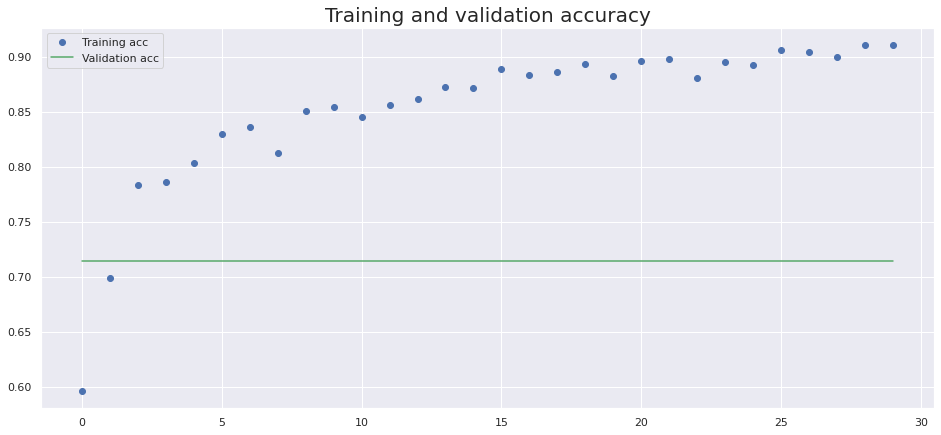

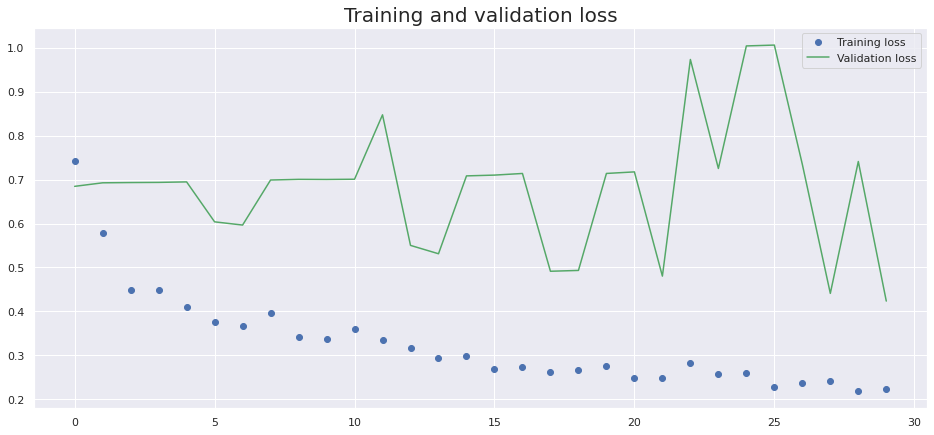

In [ ]:
plot_acc_and_loss(history)

# VGG16 Model


Transfer Learning Techniques,VGG16

We are going to use the architechure of the conventional pre trained model in our model. These models consist of two parts:convolutional base and fully connected neural network base. The convolutional base is used to identify and extract features from our images,and then the fully connected neural network base is used to classify those features.

We can add three layers to classify this dataset.  

We will use the convolutional base of VGG 16 model and the we will add one fully connected hidden layer and one output layer to classify features extracted from VGG 16 convolutional base. 

We will use pretrianed weight of Imagenet.We only want to use the convolutional part from the Imagenet model.Since convolutional bases are reusable, they are mainly used to extract features and categorize images. 

In [ ]:
# Define The parameters of my image transformation
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40, # rotating from -40 to40 degree
                               	width_shift_range=0.2, # allowing image generator to shift our images left or right  about 20% of total width
                               	height_shift_range=0.2,#allowing image generator to shift our images up or dowm  about 20% of total height
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')
 
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
    	# This is the target directory
    	train_data_dir,
    	# All images will be resized to 150x150
    	target_size=(150, 150),
    	batch_size=32,
    	# Since we use binary_crossentropy loss, we need binary labels
    	class_mode='binary')
 
val_generator = test_datagen.flow_from_directory(val_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')

Found 2480 images belonging to 2 classes.
Found 1122 images belonging to 2 classes.


In [ ]:
conv_base = VGG16(weights='imagenet',#imagenet is the final weight of vgg16 
                  include_top=False, #meaning we will import only the conv base not the whole thing
                  input_shape=(150,150,3))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
model2=Sequential()
model2.add(conv_base) #adding conv_base that was imported
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))#adding fully connected dense layer with 256 neurons
model2.add(Dense(1,activation='sigmoid')) # output layer with single neuron

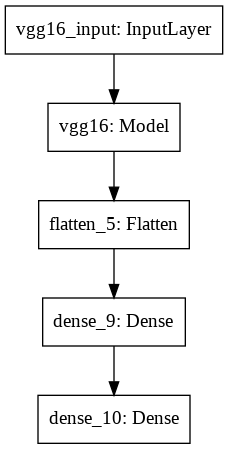

In [ ]:
#structure of model1
plot_model(model2)
# looking at the structure of my neural network

In [ ]:
model2.compile(loss='binary_crossentropy',
          	optimizer=RMSprop(lr=2e-5),# small learning rate used because weights already optimized
          	metrics=['acc'])
 
 

In [ ]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run

start = datetime.datetime.now()
history = model2.fit_generator(train_generator,
                          	steps_per_epoch=train_steps_per_epoch,
                          	epochs=30,
                          	validation_data=val_generator,
                          	validation_steps=val_steps_per_epoch)
 
end = datetime.datetime.now()
elapsed = end - start 
print('---------Elapsed Time-----------')
print('Time to fit the VGG16 model is:\n {}'.format(elapsed))



Epoch 1/30
78/78 [==============================] - 50s 636ms/step - loss: 0.3459 - acc: 0.8383 - val_loss: 0.0074 - val_acc: 0.9465
Epoch 2/30
78/78 [==============================] - 44s 561ms/step - loss: 0.2332 - acc: 0.9097 - val_loss: 0.0959 - val_acc: 0.9153
Epoch 3/30
78/78 [==============================] - 43s 555ms/step - loss: 0.1737 - acc: 0.9306 - val_loss: 5.2139e-04 - val_acc: 0.9608
Epoch 4/30
78/78 [==============================] - 45s 573ms/step - loss: 0.1470 - acc: 0.9435 - val_loss: 0.4064 - val_acc: 0.9144
Epoch 5/30
78/78 [==============================] - 44s 560ms/step - loss: 0.1434 - acc: 0.9460 - val_loss: 0.0131 - val_acc: 0.8832
Epoch 6/30
78/78 [==============================] - 43s 555ms/step - loss: 0.1327 - acc: 0.9480 - val_loss: 0.1389 - val_acc: 0.9394
Epoch 7/30
78/78 [==============================] - 43s 552ms/step - loss: 0.1183 - acc: 0.9581 - val_loss: 0.0842 - val_acc: 0.9643
Epoch 8/30
78/78 [==============================] - 43s 549ms/ste

In [ ]:
results=store_results_to_dict(model2, 'Transfer Learning Model(VGG16)')
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss
0,"Base Model(with 4 conv,pooling layers,and dens...",1.000000,0.004448,0.980392,6.014753e-07,0.869328,0.227374
1,"Hyperparameter tuned model(padding, adam)",0.995968,0.000760,0.965241,3.385009e-07,0.832123,1.097643
2,"Regularized Model(Dropout, Ridge-Lasso)",0.646371,0.768241,0.713904,4.986237e-01,0.708711,0.614174
3,Augmented Model,0.921774,0.121070,0.713904,4.236296e-01,0.708711,0.652108
4,Transfer Learning Model(VGG16),0.987097,0.023729,0.949198,6.525668e-07,0.951906,0.007795


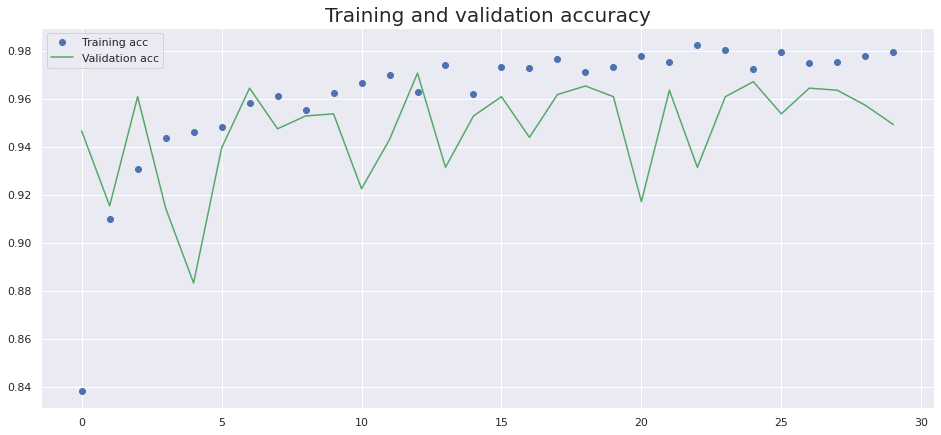

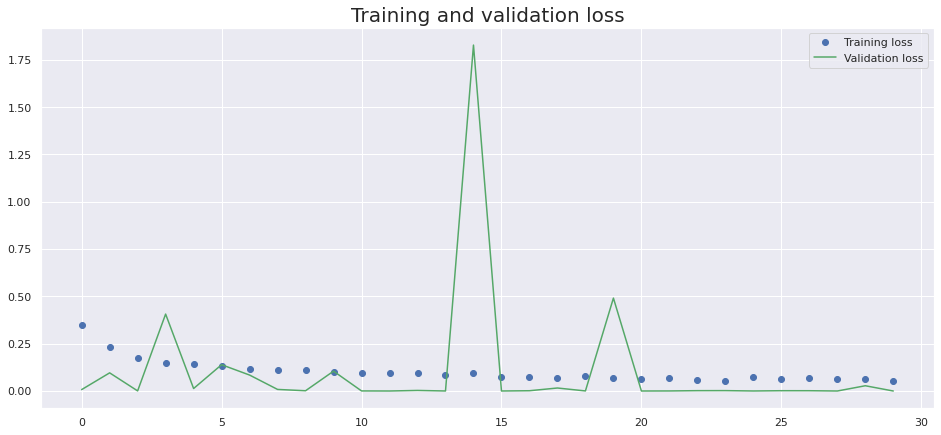

In [ ]:
plot_acc_and_loss(history)

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model2.predict_generator(val_generator, val_steps_per_epoch)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['Normal', 'Pneumonia']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[321   0]
 [801   0]]
Classification Report
              precision    recall  f1-score   support

      Normal       0.29      1.00      0.44       321
   Pneumonia       0.00      0.00      0.00       801

    accuracy                           0.29      1122
   macro avg       0.14      0.50      0.22      1122
weighted avg       0.08      0.29      0.13      1122

